In [1]:
import json

with open("config.json") as configfile:
    config = json.load(configfile)

REPLICATED_API_TOKEN = config["REPLICATED_API_TOKEN"]

### Fetching a list of intstances and denormalizing customer details

In [62]:
import requests

resp = requests.get(
    "https://api.replicated.com/v1/instances?appSelector=wordpress-enterprise",
    headers=dict(Authorization=REPLICATED_API_TOKEN),
)

instances = resp.json()

flattened = []

for instance in instances:
    license = instance.get('_embedded', {}).get('license', {})
    customer = license.get('_embedded', {}).get("customer", {})
    
    if not customer:
        raise ValueError("instance %s missing customer" % instance.get('id'))

    
    flat_instance = {k:v for (k,v) in instance.items() if k not in {'_embedded', '_resources'}}
    flat_instance['customerCreatedAt'] = customer['createdAt']
    flat_instance['customerName'] = customer['name']
    flat_instance['customerEmail'] = customer['email']
    flat_instance['customerIsArchived'] = customer['isArchived']
    flat_instance['licenseType'] = license['type']

    # fill missing data
    flat_instance['k8sVersion'] = flat_instance['k8sVersion'] or 'Unknown'
    flat_instance['k8sDistribution'] = flat_instance['k8sDistribution'] or 'Unknown'

    # leaving inactive instances in the dataset so it looks better, in reality, you probably
    # want to exclude inactive instances
    
    #if flat_instance['appStatus'] == 'inactive':
    #    continue


    flattened.append(flat_instance)

### Previewing the first instance

In [63]:
flattened[0]

{'id': '2Oxvzizx25s9Ze4LJrWy6K9VVtE',
 'firstCheckinAt': '2023-04-26T13:24:11.916Z',
 'lastCheckinAt': '2023-04-26T13:25:47.423Z',
 'firstReadyAt': '2023-04-26T13:25:47.423Z',
 'instanceTimeToInstallMinutes': 1,
 'licenseTimeToInstallMinutes': 21636,
 'licenseCreatedAt': '2023-04-11T12:49:18Z',
 'appStatus': 'inactive',
 'versionLabel': '0.1.1',
 'numberVersionsBehind': 0,
 'currentVersionReleasedAt': '2023-04-11T18:45:38Z',
 'latestVersionReleasedAt': '2023-04-11T18:45:38Z',
 'isKurl': True,
 'kurlNodeCountReady': 1,
 'kurlNodeCountTotal': 1,
 'k8sVersion': 'v1.25.5',
 'k8sDistribution': 'kurl',
 'k8sVersionsBehind': 0,
 'cloudProvider': '',
 'cloudProviderRegion': '',
 'kotsInstanceId': 'zlqihhwgppeoqrgyudhzvatzvlhapwpu',
 'kotsVersion': 'v1.98.1',
 'client': '',
 'isAirgap': True,
 'customerCreatedAt': '2023-04-11T12:49:18Z',
 'customerName': 'Omozan Industries',
 'customerEmail': 'fake@fake.com',
 'customerIsArchived': False,
 'licenseType': 'paid'}

# Basic Charting Examples

### Instances by K8s Version

Before loading data into a database, let's explore the sorts of things we can inspect just using the instance / customer data

<Axes: title={'center': 'Instances by K8s version'}, xlabel='k8sDistribution'>

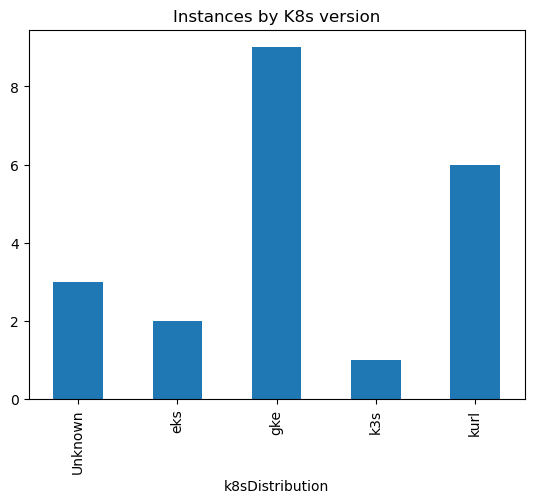

In [64]:
import pandas as pd

# convert the JSON array to a dataframe
df = pd.DataFrame(flattened)

df.groupby(['k8sDistribution'])['id'].count().plot(kind='bar', title='Instances by K8s version')
#df.plot(kind='bar', x='customerName', stacked=True, y='licenseTimeToInstallMinutes')

### Instances by App Version

Before loading data into a database, let's explore the sorts of things we can inspect just using the instance / customer data

<Axes: title={'center': 'Instances by App version'}, xlabel='versionLabel'>

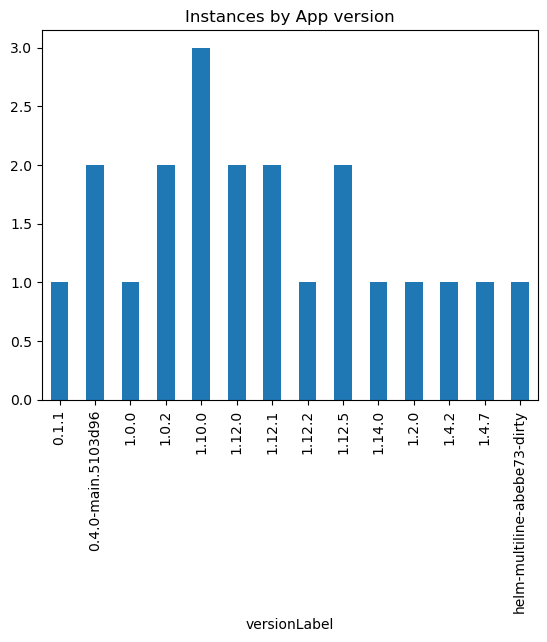

In [65]:
df.groupby(['versionLabel'])['id'].count().plot(kind='bar', title='Instances by App version')


### Instances Per Customer

Before loading data into a database, let's explore the sorts of things we can inspect just using the instance / customer data

<Axes: title={'center': 'Instances per Customer'}, xlabel='customerName'>

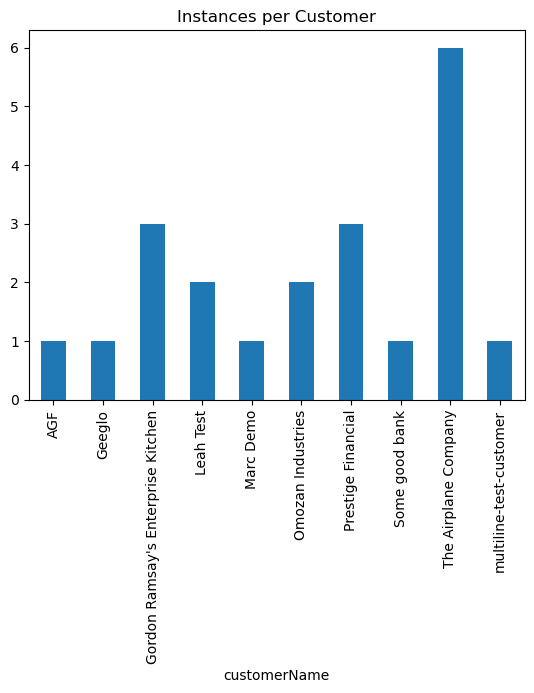

In [66]:
df.groupby(['customerName'])['id'].count().plot(kind='bar', title='Instances per Customer')


### TODO - next - set up the database

After doing some basic exploration, let's load the flattened rows into our database so we can do some more complex queries.